In [ ]:
# Benchmarking PBMC dataset with simulated CNVs
# - CD14 monocytes: Chr6 loss, Chr22 loss
# - CD4 T cells: ChrX gain

adfile_path = r"C:\Users\21lyb\Downloads\PBMC_simulated_cnas_041025.h5ad"

In [28]:
from cscb_methods import *

In [3]:
# Read file
adata = sc.read_h5ad(adfile_path)

In [4]:
# Fetch gene chromosome, start, end, and strand from Biomart
adata = fetch_positions(adata)

Request successful!


In [5]:
# Ensure that chromosomes are of the form 'chr#' and exclude any other chromosomes
adata = standardize_chromosomes(adata)

In [6]:
# Run if needed:
# adata = qc(adata)
# adata = downsample(adata,n_cells=2000)

In [7]:
# Normalize, do not log transform before CopyKAT GMM clustering
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)

In [8]:
# CopyKAT GMM clustering for automatic detection of diploid reference/normal cells vs aneuploid cells
diploid_pred,labels=identify_diploid_cells_high_precision(adata,window=10,n_components=3,primary_trim_percentile=100,secondary_trim_percentile=10)

adata.obs['predicted_diploid'] = diploid_pred
adata.obs['gmm_cluster'] = labels.astype(str)

In [9]:
# Log transform, find HVGs for UMAP plots
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.125, max_mean=6, min_disp=0.25)

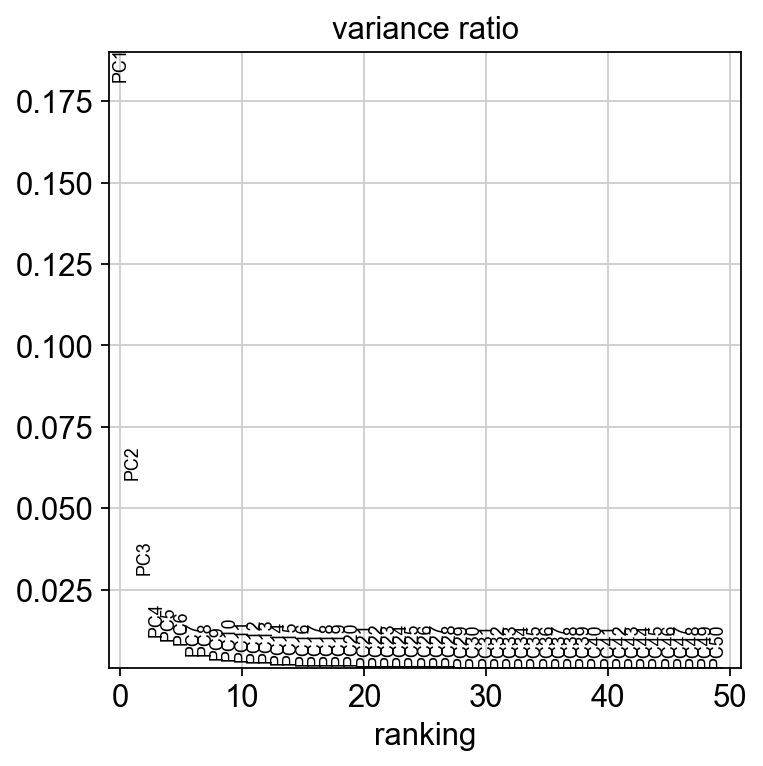

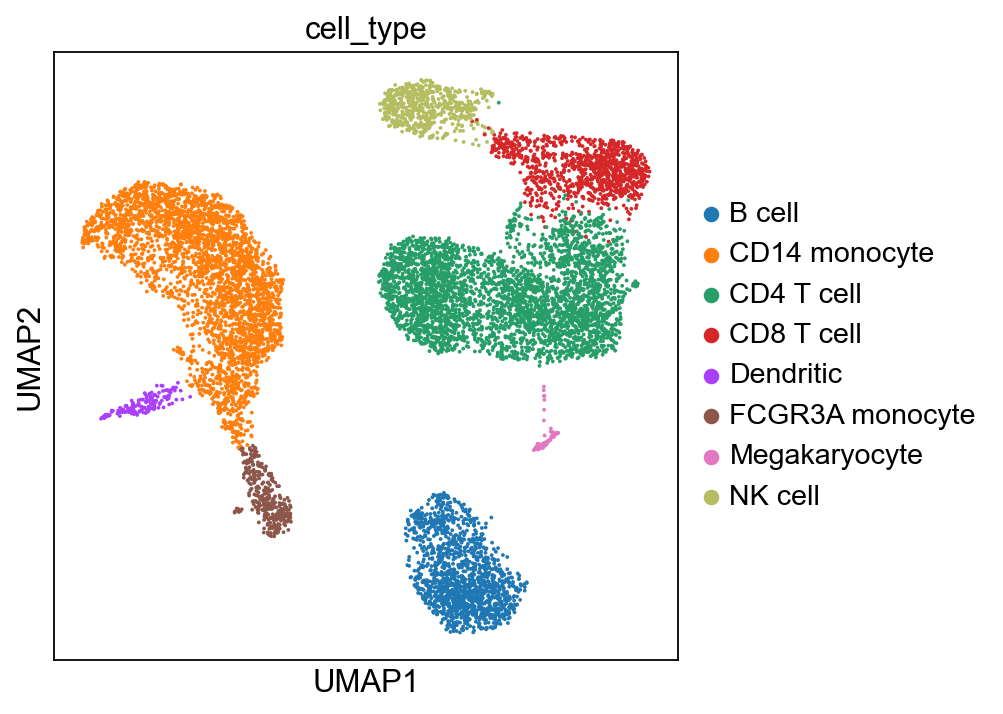

In [10]:
# PCA and KNN for UMAP plots
sc.tl.pca(adata, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata,50)

sc.pp.neighbors(adata,n_neighbors=20,n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')

In [11]:
# Quick run of InferCNVpy for Leiden clustering by CNV score
reference_key = 'predicted_diploid'
reference_cat = ['diploid']

cnv.tl.infercnv(adata,reference_key=reference_key,reference_cat=reference_cat,
                exclude_chromosomes=None,chunksize=5000,calculate_gene_values=False,
                window_size=100,step=10,dynamic_threshold=1.5)

100%|██████████| 3/3 [00:16<00:00,  5.34s/it]


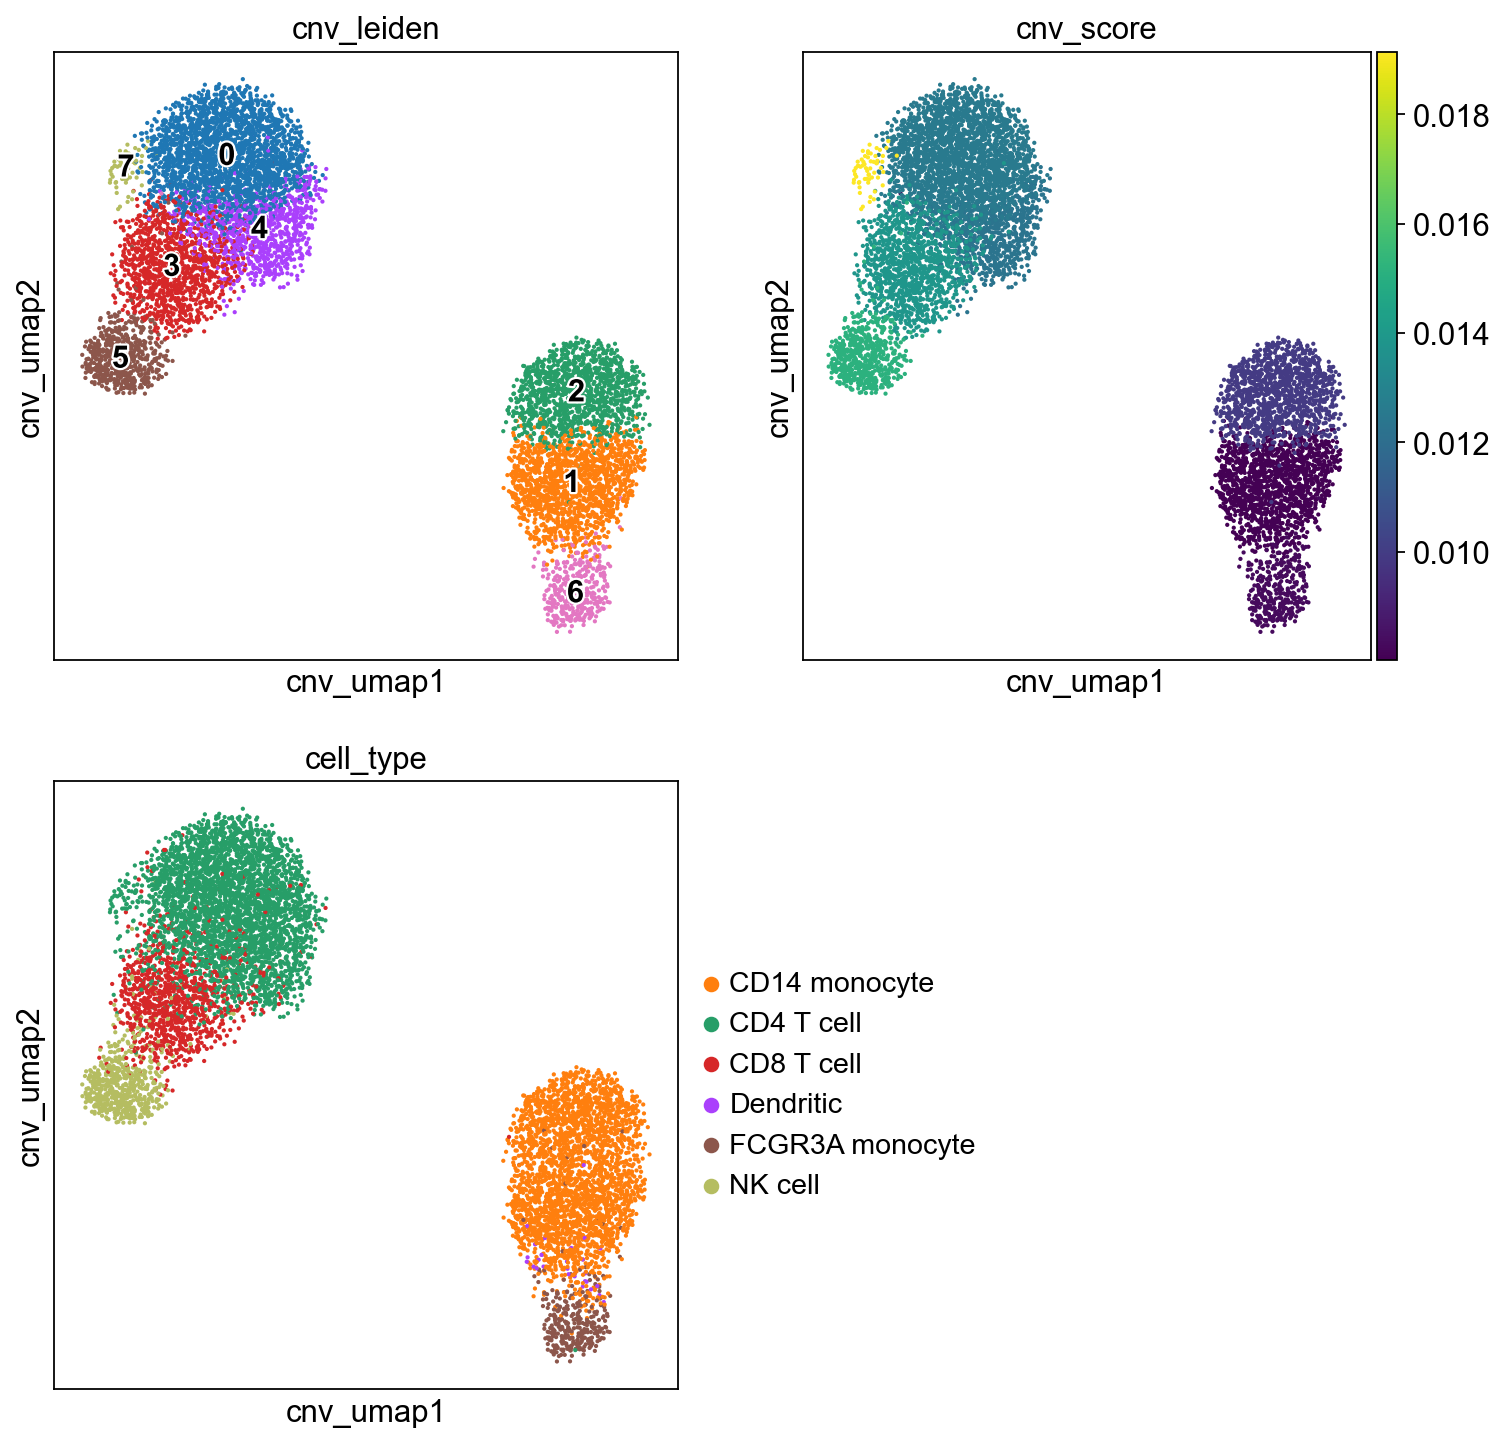

In [12]:
# Plot
plot_aneuploid_cnv_clusters(adata,diploid_annotation='predicted_diploid')

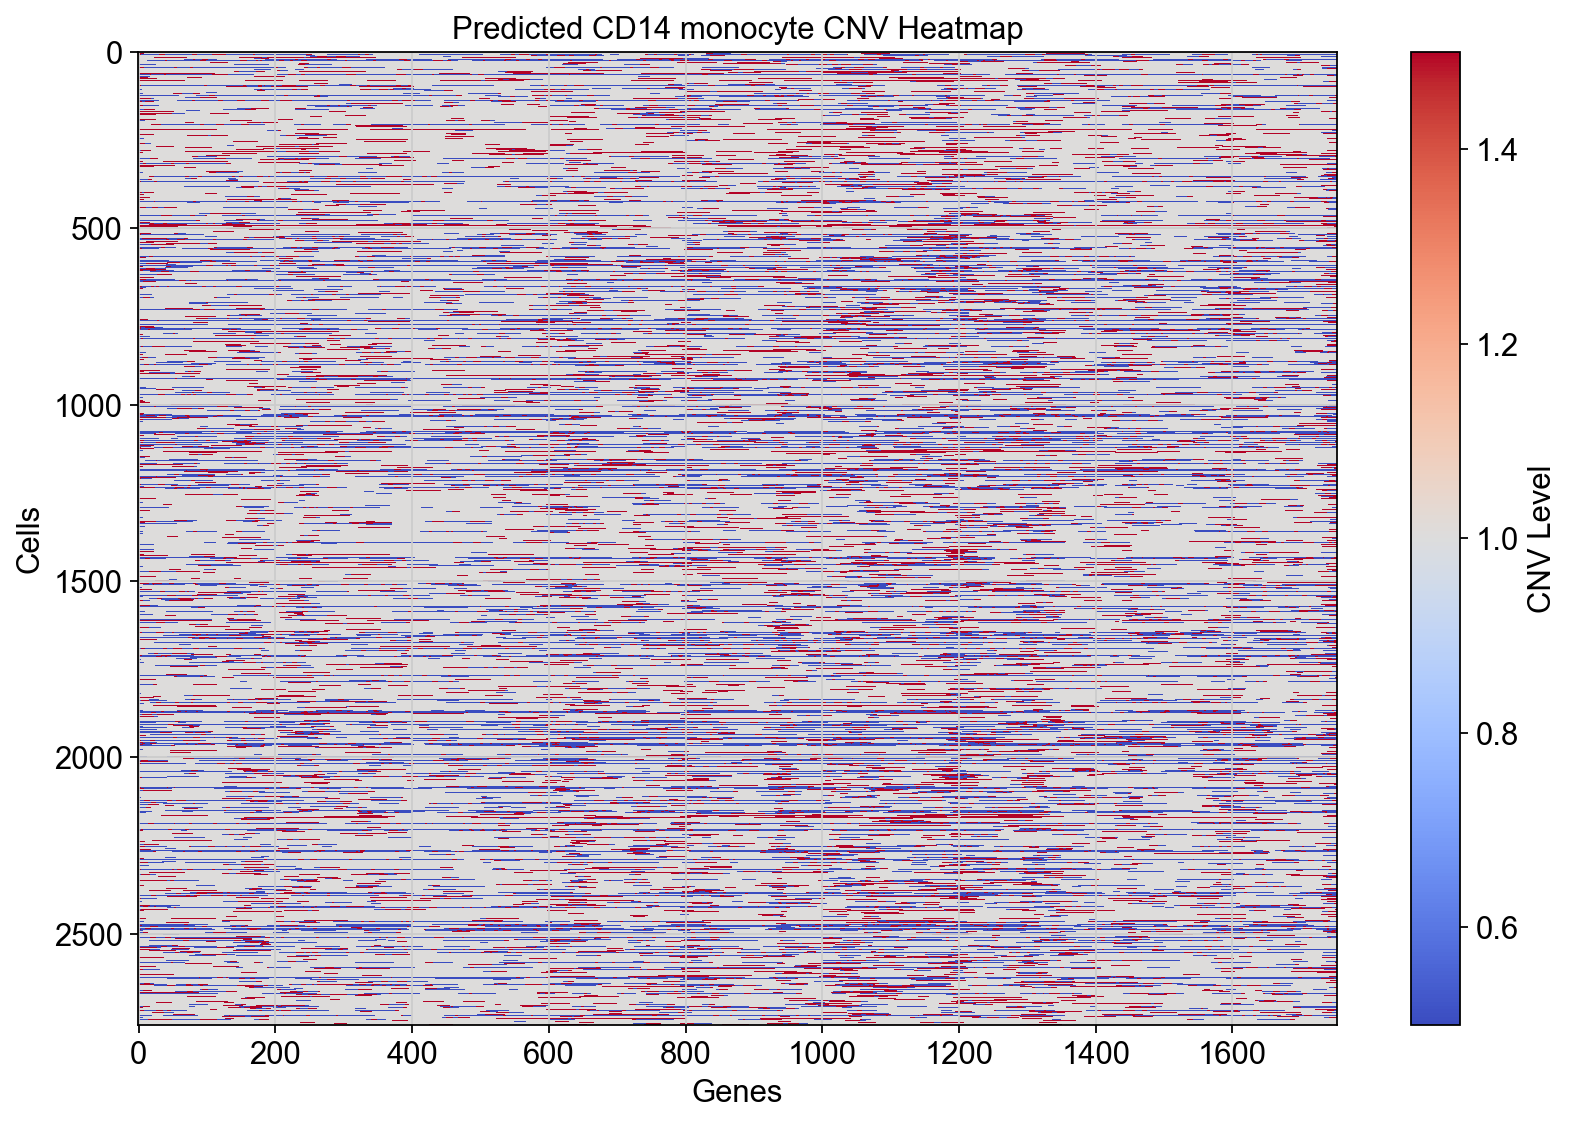

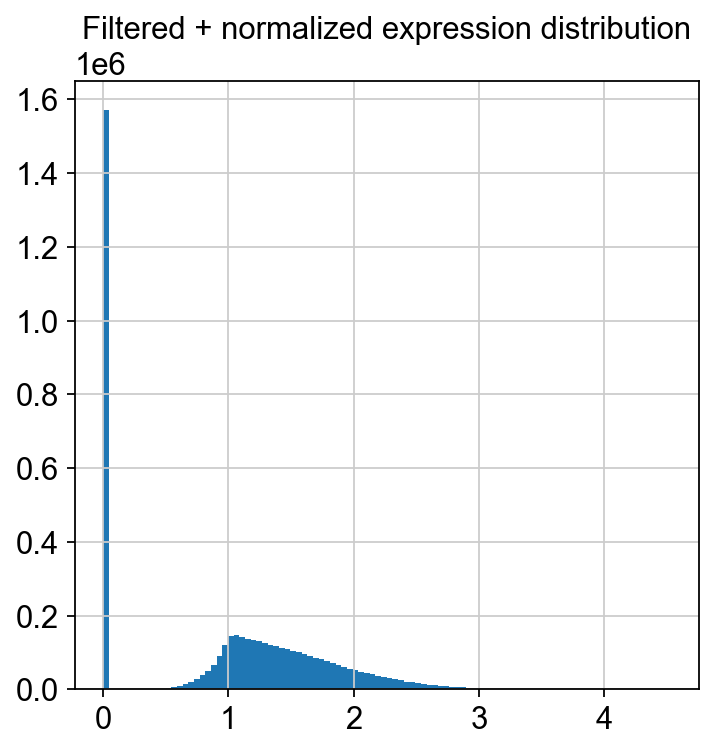

In [14]:
adata_Mono = i3_hmm_infercnv(adata,cell_type='CD14 monocyte',cell_annotation='cell_type',diploid_annotation='predicted_diploid',logFC_threshold=0.5,plots=True)

In [24]:
adata_Mono.obs

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,n_genes,n_counts,cell_type,simulated_cnvs,predicted_diploid,gmm_cluster,hmm_cnv_score,hmm_cnv
AAACCCACAGAGTTGG-1,1742,4208.0,1043.0,17.726036,633.0,10.757988,1742,4208.0,CD14 monocyte,22:19807132-29743868 (CN 0),aneuploid,1,0.812892,chr1:1373730.0-86748184.0 (loss)
AAACGAAAGACGTCGA-1,2029,5047.0,839.0,12.633639,755.0,11.368770,2029,5047.0,CD14 monocyte,22:19807132-29743868 (CN 0),aneuploid,1,0.976326,
AAACGAAAGGAGTCTG-1,3382,9202.0,1769.0,14.602939,1143.0,9.435364,3382,9202.0,CD14 monocyte,,aneuploid,1,1.034512,
AAACGCTAGGTTAAAC-1,3111,9145.0,2337.0,18.713966,1006.0,8.055733,3111,9145.0,CD14 monocyte,22:19807132-29743868 (CN 0),aneuploid,1,1.035368,
AAACGCTGTCTACATG-1,3311,10936.0,2972.0,19.857019,1059.0,7.075566,3311,10936.0,CD14 monocyte,"22:19807132-29743868 (CN 0), 6:25435484-350352...",aneuploid,1,1.025956,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCATAGACTC-1,2843,7215.0,1497.0,14.996995,1270.0,12.722900,2843,7215.0,CD14 monocyte,"22:19807132-29743868 (CN 0), 6:25435484-350352...",aneuploid,1,1.009127,
TTTGTTGAGGGCAAGG-1,2112,5033.0,971.0,14.738919,584.0,8.864602,2112,5033.0,CD14 monocyte,22:19807132-29743868 (CN 0),aneuploid,1,0.940103,chr1:1373730.0-110899936.0 (loss)
TTTGTTGCATCTGCGG-1,1068,1988.0,545.0,18.645227,390.0,13.342457,1068,1988.0,CD14 monocyte,,aneuploid,1,0.625214,chr1:1373730.0-153391073.0 (loss)
TTTGTTGGTCGGTGAA-1,3015,8283.0,1803.0,16.473276,859.0,7.848333,3015,8283.0,CD14 monocyte,22:19807132-29743868 (CN 0),aneuploid,1,1.050770,chr1:1373730.0-32686211.0 (gain)


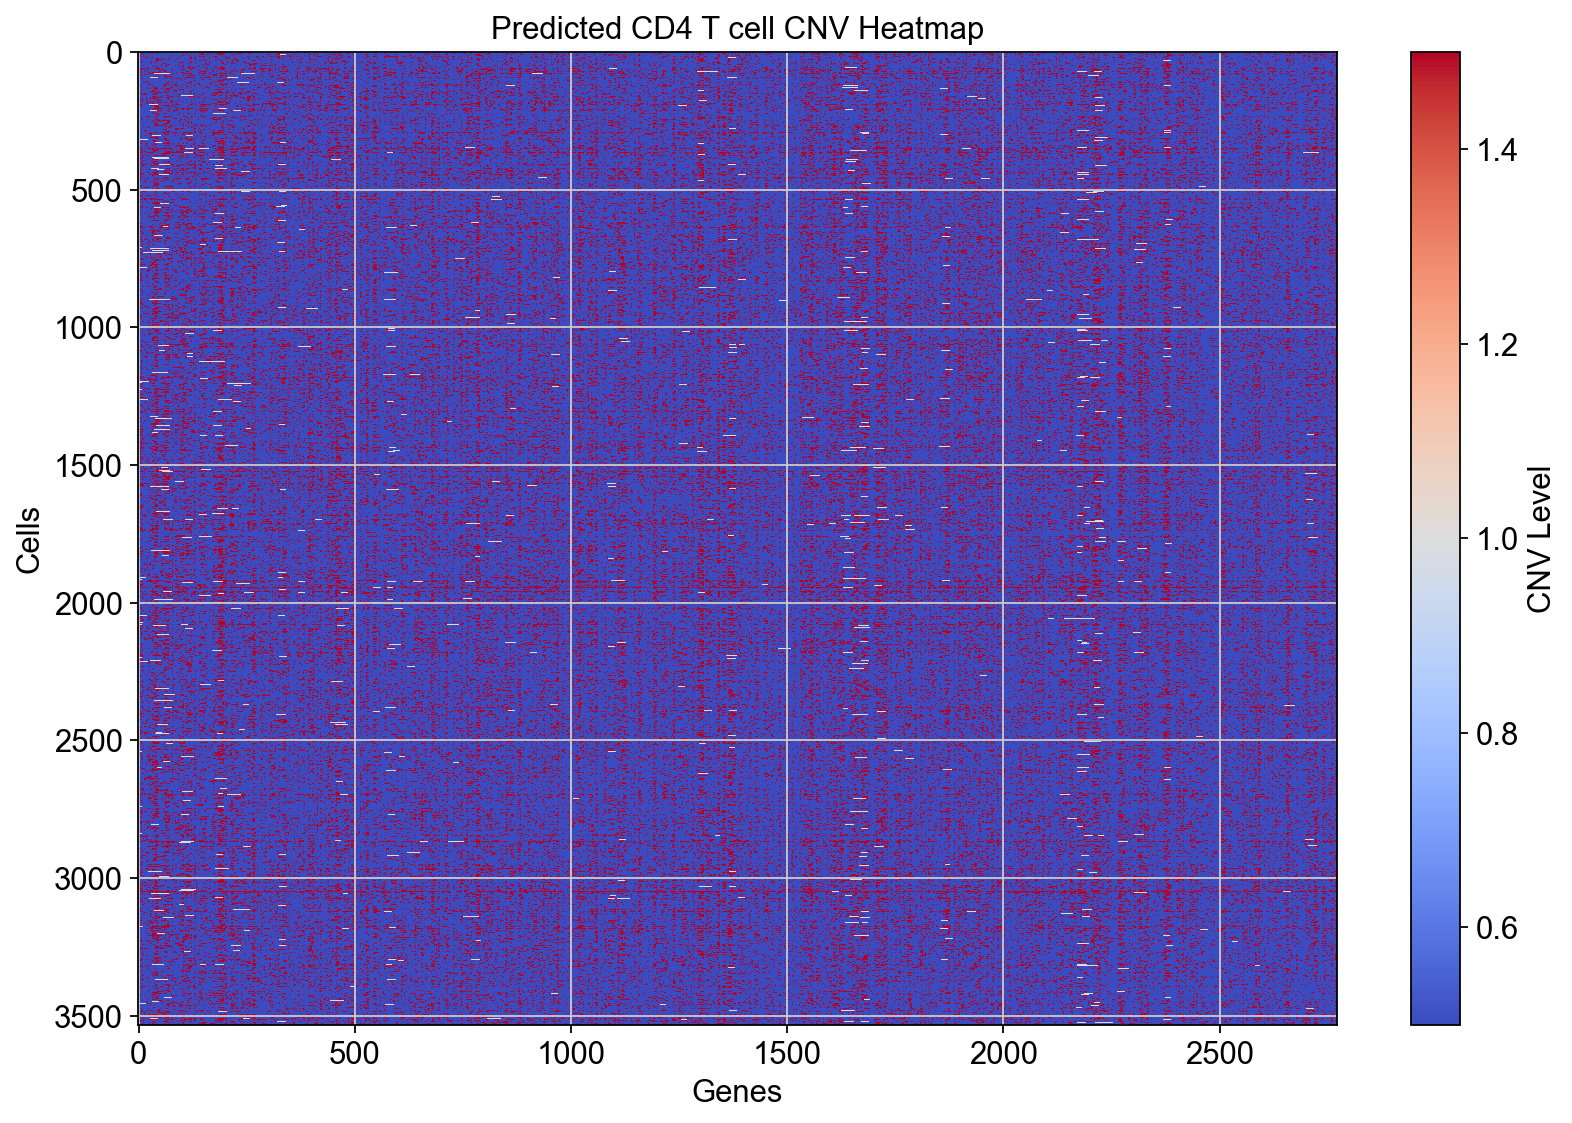

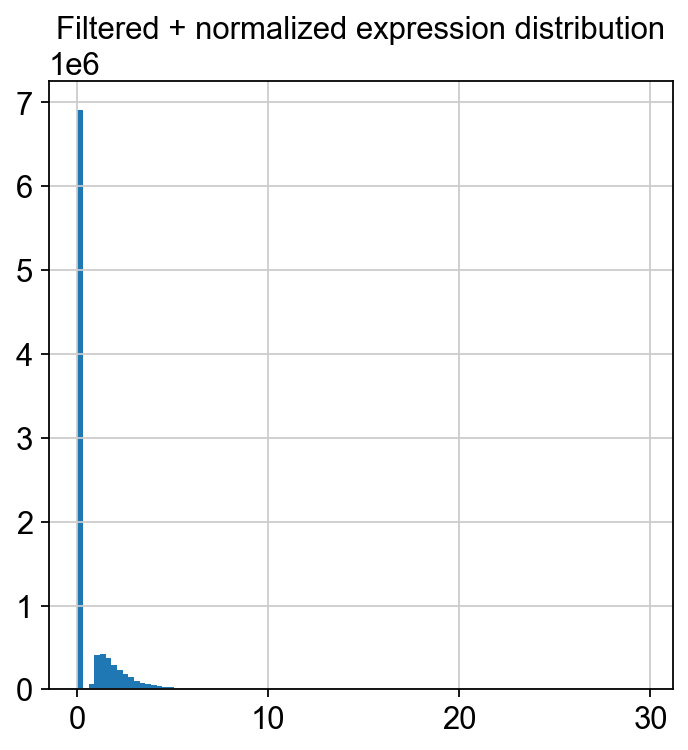

In [27]:
adata_Tcell = i3_hmm_infercnv(adata,cell_type='CD4 T cell',cell_annotation='cell_type',diploid_annotation='predicted_diploid',logFC_threshold=0.5,plots=True)

In [22]:
adata_Tcell.obs

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,n_genes,n_counts,cell_type,simulated_cnvs,predicted_diploid,gmm_cluster,hmm_cnv_score,hmm_cnv
AAACCCAAGCGCCCAT-1,1005,1760.0,392.0,17.785845,52.0,2.359347,1005,1760.0,CD4 T cell,,aneuploid,0,0.566402,chr1:1216931.0-108702928.0 (loss)
AAACCCAGTGGCTACC-1,1869,3879.0,2399.0,35.795288,424.0,6.326470,1869,3879.0,CD4 T cell,,aneuploid,0,0.715085,chr1:1216931.0-38024820.0 (loss)
AAACCCATCCCGAGAC-1,1866,4015.0,2532.0,35.702198,545.0,7.684715,1866,4015.0,CD4 T cell,,aneuploid,0,0.708769,chr1:1216931.0-65067754.0 (loss)
AAACCCATCTGGCCGA-1,1604,3033.0,1766.0,32.886406,571.0,10.633146,1604,3033.0,CD4 T cell,,aneuploid,0,0.656622,chr1:1216931.0-94518666.0 (loss)
AAACGAACAATACCCA-1,1747,3476.0,1722.0,29.674307,605.0,10.425642,1747,3476.0,CD4 T cell,,aneuploid,0,0.699747,chr1:1216931.0-30757774.0 (loss)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCTCCACA-1,2272,5065.0,3799.0,40.201057,586.0,6.201058,2272,5065.0,CD4 T cell,X:106533974-112956833 (CN 4),aneuploid,0,0.767412,chr7:73567537.0-149867479.0 (loss)
TTTGTTGCAATAGGGC-1,1839,3748.0,2061.0,32.755882,483.0,7.676414,1839,3748.0,CD4 T cell,X:106533974-112956833 (CN 4),aneuploid,0,0.680801,chr19:2425625.0-17521288.0 (loss)
TTTGTTGGTGCGTCGT-1,1245,2279.0,2471.0,48.308895,365.0,7.135875,1245,2279.0,CD4 T cell,,aneuploid,0,0.599242,chr1:1216931.0-44805995.0 (loss)
TTTGTTGTCCAAGCCG-1,1577,3093.0,1985.0,35.433773,524.0,9.353803,1577,3093.0,CD4 T cell,X:106533974-112956833 (CN 4),aneuploid,0,0.639661,chr1:1216931.0-42703805.0 (loss)


In [ ]:
# Update new CNV information back into original adata
adata.obs.loc[adata_Mono.obs_names,'hmm_cnv'] = adata_Mono.obs['hmm_cnv']
adata.obs.loc[adata_Tcell.obs_names,'hmm_cnv'] = adata_Mono.obs['hmm_cnv']

In [ ]:
assess_predicted_cnvs()